In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from livelossplot import PlotLossesKeras
import lmfit

TARGET = 'fc'

print(tf.__version__)
np.set_printoptions(precision=3, suppress=True)

2.11.0


In [2]:
#Data from https://jenfitch.com/free-chlorine-orpmv-vs-ph-new/
df = pd.read_csv('https://raw.githubusercontent.com/mzakharo/micropython/tubby/ports/esp32/orp.csv')
df_orig = df.copy()
df['bro'] = df['ppm CL'] * 2.25

print(df)
labels = df_orig.pop('ppm CL')

vs = []
for column in df_orig:
    vals= df_orig[column].to_numpy()
    c = float(column)
    for i, v in enumerate(vals):
        vs.append((v, c, labels[i]))
dataset_orig = pd.DataFrame(vs, columns= ('orp', 'ph', 'fc'))

    6.9    7  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9    8  8.1  8.2  ppm CL   
0   507  505  502  500  499  497  496  494  493  491  490  488  487    0.20  \
1   561  558  553  550  548  546  544  541  539  536  534  532  529    0.30   
2   599  596  590  586  583  580  577  574  571  568  565  562  559    0.40   
3   629  625  618  615  611  607  604  600  597  593  590  586  583    0.50   
4   652  648  640  637  632  629  625  621  617  613  610  605  602    0.60   
5   663  658  650  646  642  638  634  630  626  622  618  614  610    0.65   
6   673  669  660  656  651  647  643  639  635  630  626  622  618    0.67   
7   682  677  668  664  660  655  651  647  642  638  634  629  625    0.75   
8   690  686  677  672  668  663  659  654  650  645  641  636  632    0.80   
9   698  694  684  680  675  670  666  661  657  652  647  643  638    0.85   
10  706  702  692  687  682  677  673  668  663  658  654  649  644    0.90   
11  713  708  698  694  689  684  679  674  669  664

In [4]:
models = {}
for ph in df_orig.columns:
    if ph == 'ppm CL':
        continue      
    xdata =df[str(ph)].to_numpy()
    ydata = df['ppm CL'].to_numpy()
    lmodel = lmfit.models.ExponentialModel()
    params = lmodel.guess(ydata, x=xdata)
    fit = lmodel.fit(ydata, params, x=xdata)    
    models[str(ph)] = fit
    #print(fit.fit_report())
    #fit.plot_fit(title=str(ph))
    #fit.eval(x=p0)
models.keys()

dict_keys(['6.9', '7', '7.2', '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2'])

In [5]:
vs = []
for ph, fit in models.items():
    for orp in range(200, 1000):
        fc = fit.eval(x=orp)        
        vs.append((orp, float(ph), fc))
dataset = pd.DataFrame(vs, columns= ('orp', 'ph', 'fc'))
dataset.describe()

,orp,ph,fc
count,10400.000000,10400.000000,10400.000000
mean,599.500000,7.584615,2.283373
std,230.951031,0.397794,3.888384
min,200.000000,6.900000,0.012602
25%,399.750000,7.300000,0.086643
50%,599.500000,7.600000,0.478250
75%,799.250000,7.900000,2.637453
max,999.000000,8.200000,27.248869


In [8]:
train_dataset = dataset.sample(frac=0.8)#, random_state=0)
test_dataset = dataset.drop(train_dataset.index) #dataset_orig # dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
train_labels = train_features.pop(TARGET)

test_features = test_dataset.copy()
test_labels = test_features.pop(TARGET)

print(train_dataset.describe().transpose()[['mean', 'std']])
#sns.pairplot(train_dataset, diag_kind='kde')

inorm = tf.keras.layers.Normalization(axis=-1, input_shape=[2, ])
inorm.adapt(np.array(train_features))
onorm = tf.keras.layers.Normalization(axis=-1, invert=True)
onorm.adapt(train_labels)

           mean         std
orp  600.900841  230.682505
ph     7.585325    0.398733
fc     2.301799    3.925100


In [346]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

def build_and_compile_model(inorm, onorm):
  model = keras.Sequential([
      inorm,
      layers.Dense(8, activation='elu'),
      layers.Dense(4, activation='elu'),
      layers.Dense(1), 
      onorm,
  ])
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
model = build_and_compile_model(inorm, onorm)
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_38 (Normaliza  (None, 2)                5         
 tion)                                                           
                                                                 
 dense_181 (Dense)           (None, 8)                 24        
                                                                 
 dense_182 (Dense)           (None, 4)                 36        
                                                                 
 dense_183 (Dense)           (None, 1)                 5         
                                                                 
 normalization_39 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
Total params: 73
Trainable params: 65
Non-trainable p

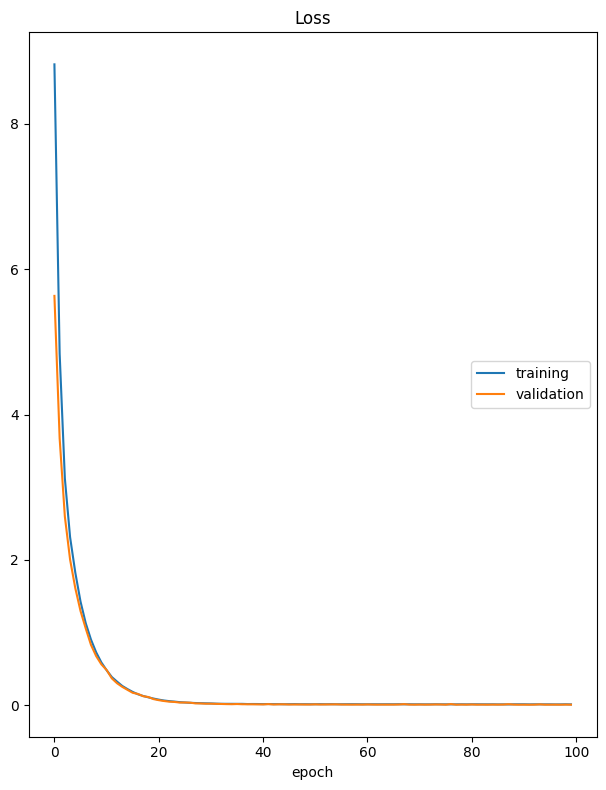

Loss
	training         	 (min:    0.013, max:    8.817, cur:    0.013)
	validation       	 (min:    0.009, max:    5.632, cur:    0.009)
208/208 [==============================] - 1s 3ms/step - loss: 0.0133 - val_loss: 0.0094
mse: 0.008476335555315018


In [347]:
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100, callbacks=[PlotLossesKeras(), model_checkpoint_callback])
print('mse:', model.evaluate(test_features, test_labels, verbose=0))

<Axes: xlabel='fc'>

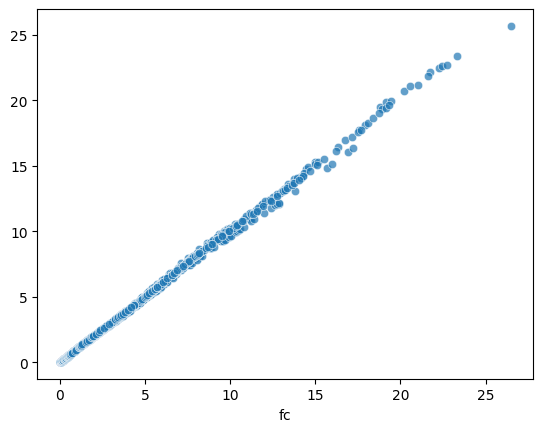

In [9]:
fmodel = checkpoint_filepath
#fmodel = 'model_fc.h5'

model = keras.models.load_model(fmodel, compile=False)
model.layers[-1].invert = True #Bug in Keras https://github.com/keras-team/keras/issues/17556


y = model.predict(test_features, verbose=0)
y = pd.DataFrame(y)[0]
sns.scatterplot(x=test_labels, y=y.to_numpy(), alpha=0.7)

In [352]:
model.save(f'model_{TARGET}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(f'model_{TARGET}.tflite', "wb") as f:
  f.write(tflite_model)
print('done')

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpfjzgrhqo\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpfjzgrhqo\assets


done


In [39]:
#model from 

def rasppool_convert(orp_mean, ph_mean):
  # Some example values:
  e_fc_adjust = 0;	# FC Adjustment in percentage
  e_fc = round( 0.23 * (1 - e_fc_adjust) * (14 - ph_mean) ** (1/(400 - orp_mean))*(ph_mean - 4.1) ** ( (orp_mean - 516)/145) + 10.0 ** ( (orp_mean + ph_mean * 70 - 1282 ) / 40 ), 1 );
  return e_fc

In [33]:
def rasppool_predict(df):
    return [rasppool_convert(v[0], v[1]) for v in df.to_numpy()]       

In [37]:
p0 = 629
p1 = 7.76
print(p0, p1)
v = model.predict([(p0, p1)], verbose=0)[0][0]
print('output: ', v, v*2.25 + LAB_OFFSET)

629 7.76
output:  0.6647371 2.6456584870815276


    7.5  ppm CL   ph      pred  rasp
0   497    0.20  7.5  0.183565   0.2
1   546    0.30  7.5  0.285672   0.3
2   580    0.40  7.5  0.386524   0.4
3   607    0.50  7.5  0.491075   0.5
4   629    0.60  7.5  0.597310   0.6
5   638    0.65  7.5  0.647423   0.6
6   647    0.67  7.5  0.702000   0.7
7   655    0.75  7.5  0.754645   0.7
8   663    0.80  7.5  0.811065   0.8
9   670    0.85  7.5  0.862649   0.8
10  677    0.90  7.5  0.916423   0.9
11  684    0.95  7.5  0.972575   1.0
12  690    1.00  7.5  1.022750   1.0
13  701    1.10  7.5  1.120114   1.1
14  712    1.20  7.5  1.225206   1.3
15  721    1.30  7.5  1.317638   1.4
16  730    1.40  7.5  1.416518   1.6
17  738    1.50  7.5  1.510359   1.8
18  753    1.70  7.5  1.703256   2.5
19  760    1.80  7.5  1.801696   3.0
20  773    2.00  7.5  2.000621   4.5
21  784    2.20  7.5  2.187229   6.9
22  800    2.50  7.5  2.493225  14.4


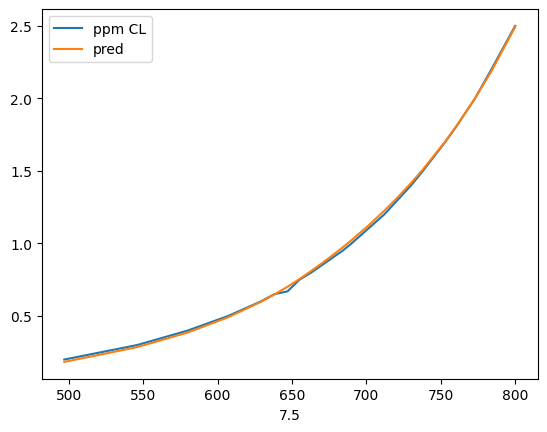

In [45]:
ph = 7.5

x = df[[str(ph),  'ppm CL']]
x = x.assign(ph=ph)
#new_row = {str(ph) : p0, 'ppm CL': 3, 'ph' : ph}
#x.loc[len(df.index)] = [p0, models[str(ph)].eval(x=p0), ph] 

x['pred'] = model.predict(x[[str(ph), 'ph']], verbose=0)
x['rasp'] = rasppool_predict(x[[str(ph), 'ph']])

print(x)
x.plot(x=str(ph), y=["ppm CL", "pred"]);

    8.2   ph      pred  rasp
0   487  8.5  0.037617   0.2
1   529  8.5  0.157362   0.3
2   559  8.5  0.288819   0.4
3   583  8.5  0.431090   0.5
4   602  8.5  0.573518   0.6
5   610  8.5  0.642891   0.6
6   618  8.5  0.718588   0.7
7   625  8.5  0.790482   0.7
8   632  8.5  0.867201   0.8
9   638  8.5  0.936116   0.9
10  644  8.5  1.008144   0.9
11  650  8.5  1.083487   1.0
12  655  8.5  1.148966   1.1
13  665  8.5  1.287837   1.3
14  674  8.5  1.422653   1.6
15  682  8.5  1.551107   2.0
16  690  8.5  1.688590   2.5
17  697  8.5  1.817218   3.2
18  710  8.5  2.079036   5.4
19  716  8.5  2.210969   7.1
20  727  8.5  2.473249  12.0
21  737  8.5  2.737148  20.0
22  751  8.5  3.152890  42.3


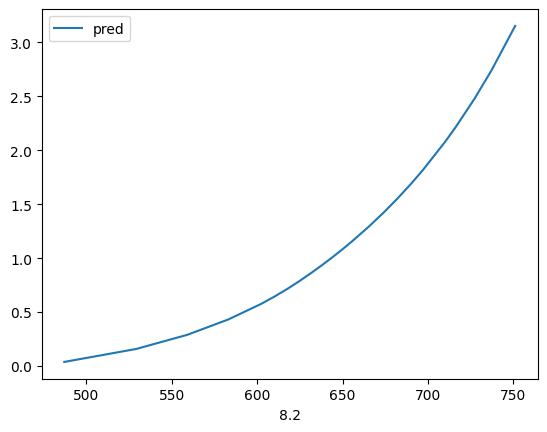

In [44]:
ph = 8.5
ph_last  = 8.2

x = df[[str(ph_last)]]
x = x.assign(ph=ph)
x['pred'] =  model.predict(x[[str(ph_last), 'ph']], verbose=0)
x['rasp'] =  rasppool_predict(x[[str(ph_last), 'ph']])

print(x)
x.plot(x=str(ph_last), y=["pred"]);